<span style="font-size:36px">Improving, extending, and understanding nearest neighbors</span>

# Big picture
* **Artificial intelligence**: Any attempt to make a machine or program act in ways traditionally associated with human intelligence, e.g., pattern recognition, creativity, learning, understanding, reasoning, dialogue 
* **Machine learning**:  Subfield of AI. Any attempt to allow a program to use data to learn, i.e., to improve at some task.
* **Supervised machine learning**: Subfield of ML. In this setting, each object of interest have features and a label. 
    
    We have some number of training points about which we know both features their features and their labels. We also have (or plan to have) some number of test points about which we only know their features.
    
 We'd like our program to predict the labels for each test point.
 
 The training set consists of **supervised examples**.
 

* **Classification**:   Subfield of ML. In this setting, objects of interest have some sort of categorical label, e.g., True/False. Our job is to assign a label to objects whose label we don't already know.


Nearest neighbor as we've seen it is a classification algorithm.
* **Regression**:   Subfield of ML. In this setting objects of interest have a continuous numerical (**real number**) label. Our job is to assign a continuous numerical label to objects whose continuous numerical label is unknown.

* **Model**:  A representation of a situation which allows us to make predictions. 

    "All models are wrong; some are useful." --George Box
    
    


* **Decision boundary**:   A representation of the regions of the feature space that correspond to each predicted label in a classification problem. E.g., if the feature space is 2D, the decision boundary should separate the plane into regions

# Training and testing

This cell contains perhaps one of the most important takeaways from the course:

If you gauge a model's performance by "testing" it with the same data on which you trained it, you are not getting a helpful or accurate number. Sometimes your accuracy will be catastrophically inaccurate.

Somehow you must train and test on different data. 

A common, simple, and easy way to do this is:

* Split your dataset into two datasets: training data and testing data
* This split should be done as early in the process as possible (ideally the very first step in data analysis)
* Train your model *only* on your training set
* Use your trained model to form predictions on the test set and compare those predictions to the known values
* Use some kind of metric to numerically evaluate how good the predictions are
* This metric for your test data is (hopefully) a somewhat reasonable estimate for how well your model will perform on truly new data (provided that the truly new data "comes from the same distribution")
* The instant you make *any* decision about your model using your test data in anyway it is likely that your test performance becomes a worse estimate for how well your model will perform on new data

Simplest metric for comparing predictions and true values for supervised classification problems: **accuracy**: the fraction of correctly predicted labels

# Nearest neighbor from last notebook:

In [2]:
import math
import numpy as np

In [3]:
def distance_2d(x1, y1, x2, y2):
    """
    Calculate the distance between (x1, x2) and (y1,y2)
    """
    return math.sqrt((x1 - x2)**2 + (y1- y2)**2)

def nearest_neighbor_2d_orig(heights, circs, labels, new_height, new_circ):
    """
    Given parallel lists of heights, circumferences, and labels
    each corresponding to a single tree, as well as the height
    and circumference of a single new tree:
    predict the label of the new tree by finding the single
    old tree that is "most similar" to the new tree (smallest distance
    between new tree and old tree when considering height and circumference
    as x and y coordinates.
    """
    
    smallest_distance = float('inf')
    label_of_smallest = None
    for i, height in enumerate(heights):
        circ = circs[i]
        label = labels[i]
        d = distance_2d(height, circ, new_height, new_circ)
        if d < smallest_distance:
            smallest_distance = d
            label_of_smallest = label
    return label_of_smallest
print("should be True:", nearest_neighbor_2d_orig( 
                               [1,2], [1,2], [True, False], 0, 0))
print("should be False:", nearest_neighbor_2d_orig( 
                               [1,2], [1,2], [True, False], 2, 3))

should be True: True
should be False: False


# Things we'd like to fix:

- Change algorithm to label several new points
- Generalize to not just trees
- Generalize to higher dimensions
- Efficiency
- Timing
- Stop using parallel arrays
- Handle noise
- Test in less ad hoc way
- Understand cases where nn does well and where it doesn't



## Generalizing to arbitrary features:

In the below cell we improve the above code by removing all references to problem specifics like height and circ and instead adapt a more general terminology

In [4]:
def nearest_neighbor_2d(feature1s, feature2s, labels,
                          new_feature1, new_feature2):
    """
    Given multiple 2d points and labels associated with them
    as well as a single additional 2d point, 
    predict the label of the new point using the label of 
    the old point which is the smallest distance from the new point.
    """
    smallest_distance = float('inf')
    label_of_smallest = None
    for i, feature1 in enumerate(feature1s):
        feature2 = feature2s[i]
        label = labels[i]
        d = distance_2d(feature1, feature2, 
                     new_feature1, new_feature2)
        if d < smallest_distance:
            smallest_distance = d
            label_of_smallest = label
    return label_of_smallest

print("should be True:", nearest_neighbor_2d( 
                               [1,2], [1,2], [True, False], 0, 0))
print("should be False:", nearest_neighbor_2d( 
                               [1,2], [1,2], [True, False], 2, 3))

should be True: True
should be False: False


## Handling multiple new "points"
In practice we often want to predict a label for a whole bunch of points at once rather than a point at a time. We'll make a new function to handle this for us.

Note the name change of the function below (it's now neighbors plural)

In [5]:
def nearest_neighbors_2d(feature1s, feature2s, labels,
                     new_feature1s, new_feature2s):
    """
    Given multiple 2d points and labels associated with them
    as well as multiple additional 2d points, 
    predict the label of each new point using the label of 
    the old point which is the smallest distance from the new point.
    """
    results = [None] * len(new_feature1s)
    for i, new_feature1 in enumerate(new_feature1s):
        new_feature2 = new_feature2s[i]
        results[i] = nearest_neighbor_2d(
            feature1s, feature2s, labels,
            new_feature1, new_feature2
        )
    return results

print("should be [True, False]:", nearest_neighbors_2d( 
                               [1,2], [1,2], [True, False], [0, 2], [0,3]))

should be [True, False]: [True, False]


# Entering the 3rd dimension?!
What if we had a problem with more than 2 good choices for features?
    
Should we try to choose 2 of them? No! We should find a way to use all 3!

It's not hard to modify the above code to work in 3d

In [6]:
def distance_3d(this_feature1, this_feature2,this_feature3,
                other_feature1, other_feature2, other_feature3):
    """
    Calculate the distance between 
    (this_feature1, this_feature2, this_feature3)
    and (other_feature1, other_feature2, other_feature3)
    """
    return math.sqrt((this_feature1 - other_feature1) ** 2 +
                     (this_feature2 - other_feature2) ** 2 +
                     (this_feature3 - other_feature3) ** 2 )

def nearest_neighbor_3d(feature1s, feature2s, feature3s, labels,
                       new_feature1, new_feature2, 
                        new_feature3):
    """
    Given multiple 3d points and labels associated with them
    as well as a single additional 3d point, 
    predict the label of the new point using the label of 
    the old point which is the smallest distance from the new point.
    """
    smallest_distance = float('inf')
    small_label = None
    for i, feature1 in enumerate(feature1s):
        feature2 = feature2s[i]
        feature3 = feature3s[i]
        label = labels[i]
        d = distance_3d(feature1, feature2, feature3, 
                        new_feature1, new_feature2, new_feature3)
        if d < smallest_distance:
            smallest_distance = d
            small_label = label
    return small_label

def nearest_neighbors_3d(feature1s, feature2s, feature3s, labels,
                       new_feature1s, new_feature2s, 
                        new_feature3s):
    """
    Given multiple 3d points and labels associated with them
    as well as multiple additional 3d points, 
    predict the label of each new point using the label of 
    the old point which is the smallest distance from the new point.
    """
    results = [None] * len(new_feature1s)
    for i, new_feature1 in enumerate(new_feature1s):
        new_feature2 = new_feature2s[i]
        new_feature3 = new_feature3s[i]
        results[i] = nearest_neighbor_3d(feature1s, feature2s, feature3s,
                                     labels, new_feature1, new_feature2, 
                                     new_feature3)
    return results

print("should be [True, False]:",nearest_neighbors_3d(
    [1,2], [1,2], [1,2], [True, False],
    [0, 2], [0,3], [0,4]))

should be [True, False]: [True, False]


# Higher dimensions?!
What if we had a problem with 4 good choices for features? 

Should we choose 3 of them? No! We should find a way to use all of them!

Well, then, should I write nearest_neighbor(s)_4d? 
I guess 3d wasn't that hard.

What about 5d and 6d and 7d? 10d? 100d? 

Hmmmm, there must be a better way.

If we treat each datapoint as something like a list then we'll be able to have datapoints with an arbitrary amount of features

In [7]:
def distance(this_point, other_point):
    """
    Calculate the distance between 
    this_point and other_point where both are assumed to be
    lists of numbers
    """
    sum = 0
    for i, this_feature_i in enumerate(this_point):
        other_feature_i = other_point[i]
        sum += (this_feature_i - other_feature_i) ** 2
    return math.sqrt(sum)

def nn(train_points, labels, test_point):
    """
    Given multiple train_points (each a list of numbers) and 
    labels associated with them
    as well as a single test_point (a list of numbers), 
    predict the label of the new point using the label of 
    the train point which is the smallest distance from the test point.
    """
    smallest_distance_yet = float('inf')
    small_label = None
    for i, train_point in enumerate(train_points):
        label = labels[i]
        d = distance(train_point, test_point)
        if d < smallest_distance_yet:
            smallest_distance_yet = d
            small_label = label
    return small_label

def nns(train_points, labels, test_points):
    """
    Given multiple train_points (each a list of numbers) and 
    labels associated with them
    as well as a multiple test_points (a list of numbers), 
    predict the label of each test point using the label of 
    the train point which is the smallest distance from the test point.
    """
    results = [None] * len(test_points)
    for i, test_point in enumerate(test_points):
        results[i] = nn(train_points, labels, test_point)
    return results

print("should be [True, False]:",nns(
    [[1, 1, 1], [2, 2, 2]], [True, False],
    [[0, 0, 0], [2, 3, 4]]))

should be [True, False]: [True, False]


# Vectors and matrices

## Vectors
* for our purposes, a vector will be an ordered list of numbers
* each number in a vector is called one component
* in physics you might learn (have learned) that a vector is a magnitude and a direction
* both of these are true and do not contradict each other
* vectors are often represented visually as arrows pointing in some direction with the length corresponding to its magnitude
* In physics, you often translate vectors around the space willy nilly. Such vectors are called free vectors
* For the most part, we will restrict ourselves to *bound vectors* with the tail of the arrow stuck to the origin
* often we drop the arrow and simply think of a vector as the point that sits at the tip of the arrow
* our notion of vector as an ordered list of numbers can be translated to the physics notion of a vector by drawing a point at the coordinates specified by the list of numbers and drawing an arrow from the origin to the point
* The physics notion of a vector can be translated to our notion of a vector by making sure the vector's tail is at the origin and then finding the coordinates of the tip of the vector
* We will often like to think about the space of all possible vectors of the same dimension. These are called vector spaces. 
* The Cartesian plane is a vector space. I'll often call this space $\mathbb{R}^2$
* The 3D Cartesian space is a vector space. I'll often call this space $\mathbb{R}^3$
* We usually use a lowercase letter to represent vectors. It's common to use either a bold letter or a letter with an arrow above. E.g., $\bf{x}$ or $\vec{x}$
* We've already represented a vector in python using a list. We'll meet other ways to represent a vector in python in the near future
* When we're doing math with vectors, we typically write them like this:
$$\vec u = \begin{pmatrix} 1\\5\end{pmatrix}$$
* If we want to talk about particular components of a vector, we typically do this with subscripting, e.g., 

$$u_0 = 1, u_1 = 5$$

Note that sometimes people use 0-based counting and sometimes people use 1-based counting. Sorry about that. In this class I'll try to mostly use 0-based counting
###  Vector math
### Vector addition
* We can add vectors by adding them componentwise. 
* Adding vectors can be represented visually by sliding one vectors tail to the other's tip, and drawing the result vector from the origin to the tip of the second vector.

E.g.,
$$\vec u = \begin{pmatrix} 1\\5\end{pmatrix}$$

$$\vec v = \begin{pmatrix} 3\\3\end{pmatrix}$$

$$\vec u + \vec v = \begin{pmatrix} 4\\8 \end{pmatrix}$$

#### Connections between arrow idea and list idea
* Think of each component of a vector by indicating a distance along the corresponding axis
* Equivalently, think of a vector as being directions for how to get from the origin to the point at the tip of the vector. You can walk directly along the arrow in the specified direction for the specified magnitude. Alternatively, you can walk along the first axis the distance specified by the first component of the vector, walk parallel to the second axis the distance specified by the second component of the vector,..., walk parallel to the m-th axis the distance specified by the m-th component

### Scalar multiplication
* We can also multiply vectors by "normal" numbers
* In arrow world, this corresponds to multiplying the magnitude by the absolute value of the "normal" number
* If the "normal" number is negative also reverse the direction of the vector
* In oredered list world, multiplying a vector by a number corresponds to multiplying each component of the vector by the "normal" number
* We can think of this multiplication as "scaling" the vector, whence scalar multiplication
* When we're dealing with vectors, we typically call "normal" numbers scalars for this reason

### Standard unit vectors

Vectors with magnitude 1 are called unit vectors. 

Some particularly useful unit vectors are called **standard unit vector**. These vectors point in the direction of one of our axes (and of course have magnitude 1).

For example in $\mathbb{R}^2$ we will name the unit vectors like so:

$$\vec e_0 = \begin{pmatrix}1 \\ 0\end{pmatrix}, \quad \vec e_1 = \begin{pmatrix}0 \\ 1\end{pmatrix}$$

In $\mathbb{R}^3$:

$$\vec e_0 = 
\begin{pmatrix}
1 \\ 0\\0
\end{pmatrix},
\quad \vec e_1 = 
\begin{pmatrix}
0 \\ 1\\ 0
\end{pmatrix},
\quad \vec e_2 = 
\begin{pmatrix}0 \\ 0\\ 1
\end{pmatrix}$$

etc., 


Generally we'll be working with one vector space at a time and we won't need to differentiate between the $\vec e_1$ that's associated with $\mathbb{R}^2$ and the $\vec e_1$ that's associated with $\mathbb{R}^3$





### Linear algebra
The reason we're messing around  with all this vector stuff is that by thinking of our datapoints (e.g., trees) as vectors we give ourselves the opportunity to use all kinds of mathematics, notably linear algebra.

One of the most important concepts in linear algebra is the notion of a vector.

Most things in linear algebra can be boiled down to adding vectors and performing scalar multiplication on vectors.

### Helpful video
https://tinyurl.com/aihVectorMaths

* It is useful to associate a single number with vectors. Mathematicians have a special word for a particular type function that assigns a positive number to each vector in a vector space (except for the zero vector which gets assigned 0) (and follows some other rules). This word is **norm**
* **norm**: a function that takes in a vector and outputs a non-negative real number, e.g., $\|\vec e_0\| = 1$ and follows some particular rules.:
    *  The norm of the 0-vector ($\vec 0$, the vector with all components 0) must be 0. The norm of all other vectors is strictly positive
    * $\|\vec u + \vec v\| \leq \|\vec u\| + \|\vec v\|$. This called the triangle inequality
    * $\|a\vec v\| = |a|\|\vec v\| $
* We can think of norms as something like a distance, but they don't have to be the normal sense of distance
* most often, we use the norm that actually literally calculates the length of the vector (magnitude), that is, the squareroot of the sum of the components
* this typical norm is sometimes called the Euclidean norm, the Euclidean distance, the l2 norm, the l2 distance, the L2 distance, the L2 norm, etc.
* Another common norm is the sum of the absolute values of the component. 
* This norm is called the l1 norm, the L1 norm, the L1 distance, l1 distance, the taxicab norm, the manhattan distance, etc.
* We often write L2 distance as $\|\vec v \|_2$ and L1 distance as  $\| \vec v \|_1$ if it's not clear from context what we're talking about
* For a D-dimensional vector $\vec x$, $$\|\vec x \|_2 = \sqrt{x_0^2 + x_1 ^2 + \cdots + x_{D-1} ^2} = \sum_{i = 0}^{D -1 }{x_i^2}$$
* For a D-dimensional vector $\vec x$, $$\|\vec x \|_1 = \sqrt{|x_0| + |x_1| + \cdots + |x_{D-1}| } = \sum_{i = 0}^{D -1 }{|x_i|}$$


In [8]:
def norm(x, norm_type=2):
    sum = 0
    if norm_type is float('inf'):
        norm_type = 0
    for i, term in enumerate(x):
        sum += abs(term) ** norm_type
    return sum ** (1.0/ norm_type)
print(norm([2, 3, 1], 2))
print(norm([2, 3, 1], 1))

3.7416573867739413
6.0


# Matrices

* Another useful concept in linear algebra is called a matrix.
* The CS perspective of a matrix is a rectangular array of numbers
* When doing math, we typically name matrices with capital letters.
* We write matrices like: $$A = \begin{pmatrix}1 &5\\2& 3\end{pmatrix}$$

$$B = \begin{pmatrix}2 & 3& 4\\0 & -1 & 3.2\end{pmatrix}$$
* We can refer to individual elements of a matrix using subscripting with 2 numbers. The first number indexes the row, the second number indexes the column. e.g., $A_{0,0} = 1, A_{0,1} = 5$
* When thinking about matrices it's useful to think about the shape of the matrix. E.g., A is a 2 by 2 matrix. B is a 2 by 3 matrix
* Sometimes it's useful to talk about the set of all matrices of the same shape. E.g., $A$ is a member of $\mathbb{R}^{2\times2}$ and $B$ is a member of the set $\mathbb{R}^{2 \times 3}$
* Note that vectors can be thought of as special cases of a matrix, those with only 1 column.
* In general, we can also think of matrices as bundles of vectors. E.g., if we have the vectors $\vec u = \begin{pmatrix}1\\2\end{pmatrix}$ and $\vec v = \begin{pmatrix}5\\3\end{pmatrix}$. We could write $A = \begin{pmatrix} \vec u & \vec v\end{pmatrix}$.
* When working with matrices (or vectors) sometimes it's useful to "swap" the rows and the columns. This is called taking the transpose. 
    * Here are the transposes of $A$ and $B$: 
    $$A^\top = \begin{pmatrix}1 &2\\5& 3\end{pmatrix} $$
    
    $$B = \begin{pmatrix}2 & 3& 4\\0 & -1 & 3.2\end{pmatrix}$$
    * We can think of the transpose as "flipping" across the diagonal. Note that the diagonal remains unchanged
    * Note that the transpose of a matrix has the same number of rows as the original had columns and vice versa
    * We can also transpose vectors. E.g.,  when $\vec v = \begin{pmatrix}5\\3\end{pmatrix}$, the transpose,  $\vec v^\top = \begin{pmatrix}5 & 3\end{pmatrix}$. 
    * The transpose of a normal vector is sometimes called a row vector.
    
* Going forward as we think about each individual datapoint as a vector, we'll also think about a list of datapoints as a matrix.
* If each of our datapoints are named $\vec x_0, \vec x_1, \vec x_2, \ldots \vec x_{N-1}$ and all of those are D-dimensional vectors (i.e., they are all elements of $\mathbb{R}^D$), then we can think of the whole dataset as one matrix, $$X = \begin{pmatrix} \vec x_0^\top \\\vec x_1^\top \\ \vec x_2^\top\\ \vdots\\ \vec x_{N-1}^\top  \end{pmatrix}$$

$X$ is a $N$ by $D$ matrix (i.e., $X$ is a member of $\mathbb{R}^{N \times D}$)

# Numpy
[Website](https://numpy.org)

### What is numpy?
numpy is a python module for numeric computing in python whence the name numpy. Much of numeric computing revolves around matrices/vectors/similar concepts. Numpy is made to work very well with things like matrices. Like any module we need to import it before we can use it.

### Why numpy?
* vanilla python is much slower than some other languages
* numpy has many many functions and each of them do their heavy-lifting in a generally faster language (C or C++)
* math-heavy code (particularly code involving matrices and vectors) will often be orders of magnitude faster if you do it "the numpy way" vs. doing it all in vanilla python
* When working with matrices and vectors, code written using numpy will often be much simpler and easier to read than code to do the same thing in vanilla python

### ndarrays
[Documentation](https://numpy.org/devdocs/reference/generated/numpy.ndarray.html?highlight=ndarray#numpy.ndarray)
ndarrays are the most common ways of representing vectors or matrices in numpy
* ndarray stands for n-D array as in, an n-dimensional array where n is some non-negative integer
* a 1-D array is a natural way to represent a vector
* a 2-D array is a natural way to represent a matrix
* a 0-D array is one way (although not the most common way) to represent a normal number (scalar)
* note that the dimension here is completely different from the dimension of the vector


In [9]:
import numpy as np
x = [[1,2,3], [4,5,6]] # vanilla python: 
# one way to represent a matrix
print("vanilla python:\n", x)
x_np = np.array(x) # x_np is now an ndarray
print("type of x_np:", type(x_np))
print("np:\n", x_np)

vanilla python:
 [[1, 2, 3], [4, 5, 6]]
type of x_np: <class 'numpy.ndarray'>
np:
 [[1 2 3]
 [4 5 6]]


In [10]:
import numpy as np
v = [1,2,3] # vanilla python: 
# one way to represent a vector
print("vanilla python:\n", v)
v_np = np.array(v) # v_np is now an ndarray
print("type of v_np:", type(v_np))
print("np:\n", v_np)

vanilla python:
 [1, 2, 3]
type of v_np: <class 'numpy.ndarray'>
np:
 [1 2 3]


As a quick demonstration of how much simpler working with vectors can be in numpy vs vanilla python consider the example of trying to add two vectors.

In vanilla python, the most obvious way involves writing a function to do it. In numpy we don't need a special function and it takes a single line

In [11]:
ulist = [1, 2, 0]
vlist = [2, 1, 3]
def sum_vector(xlist, ylist):
    result = [None] * len(xlist)
    for i, xterm in enumerate(xlist):
        result[i] = xterm + ylist[i]
    return result
zlist = sum_vector(ulist, vlist)
print("Vanilla:")
print("u:\t", ulist)
print("v:\t", vlist)
print("u + v:\t", zlist)
print("#" * 20)


u_np = np.array(ulist)
v_np = np.array(vlist)
z_np = u_np + v_np
print("Vanilla:")
print("u:\t", u_np)
print("v:\t", v_np)
print("u + v:\t", z_np )
print("#" * 20)


Vanilla:
u:	 [1, 2, 0]
v:	 [2, 1, 3]
u + v:	 [3, 3, 3]
####################
Vanilla:
u:	 [1 2 0]
v:	 [2 1 3]
u + v:	 [3 3 3]
####################


We can also do component-wise subtraction, multiplication, and division in the same way.

You can even do the same thing for matrices (provided the shapes match)

## Shape of ndarrays
Intuitively we probably have some idea of what the shape of an ndarray might be. The details of how it works in numpy are sometimes slightly different than our intuition but remain pretty close.

If we have some numpy ndarray ```foo```, we can get its shape by ```foo.shape```.

If we had a matrix with 2 rows and 3 columns we might describe its shape as a 2 by 3 grid.

If we ask numpy we get ```(2, 3)```

Sensible enough.

How about a vector ```v``` with 3 components?

We get ```(3,)```.

The shape of an ndarray will always be a **tuple**

A **tuple** is an ordered sequence of elements (for shapes the elements will always be ints. Tuples are not exclusively used for shapes nor even exclusively used for numpy. 

(Where did the word tuple come from? Tuple came from a generalization of single, couple, triple, quadruple, quintuple, ..., n-tuple)

Tuples can have 0 elements, 1 element, 2 elements, 3 elements, etc.

In python, because parentheses are also used for grouping we need to be able to distinguish from a 1-tuple (that is a tuple containing only a single element) and a single thing. We do this with that weird trailing comma syntax.

E.g.,:

```(100,)``` is a 1 tuple containing 100 whereas ```(100)``` and ```100``` are both the normal int 100.

We can index and slice tuples just like lists.

How would we get the number of rows of an ndarray ```x``` (corresponding to a matrix)?

```python
print(x.shape[0])
```

In [12]:
x = np.array([[1, 2, 3], [4, 5, 6]])
print("x:\n", x)
print("x's shape:", x.shape)
print("x # of rows:", x.shape[0])
print("x # of cols:", x.shape[1])
print("#" * 20)
v = np.array([1, 2, 3])
print("v:\n", v)
print("v's shape:", v.shape)

x:
 [[1 2 3]
 [4 5 6]]
x's shape: (2, 3)
x # of rows: 2
x # of cols: 3
####################
v:
 [1 2 3]
v's shape: (3,)


## Shape of ndarrays that represent vectors

We've already seen that we can represent a vector as a 1darray (an array whose shape is a 1-tuple). This works for all vectors.

However, it's not the only way to represent a vector. This might seem strange but remember we've already met another other way to represent a vector: a simple list. In CS there are often multiple ways for the computer to represent the same concept.


Typically we will represent a vector as a 1darray but it's good to recognize other options exists.

Since a vector is essentially equivalent to a matrix with a single column, we could also represent a vector as a 2darray with however many rows and a single column. It's shape would be a 2-tuple.

Note how we create such a creature:
```python
v_col = np.array([[1], [2], [3], [4]])
```

We could also treat the vector explicitly as a row vector, something with a single row and however many columns. Again this would be a 2darray and its shape would be a 2-tuple.

Note how we create such a creature:
```python
v_row = np.array([[1], [2], [3], [4]])
```

**Again we will typically use the 1darray perspective for vectors, but sometimes we might use one of the 2darray perspectives (explicitly a column vector or a row vector)**

In [13]:
print("A 4 dimensional vector represented as a 1darray")
v = np.array([1, 2, 3, 4])
print("v:\n", v)
print("v's shape:", v.shape)
print("#" * 20)
print("The same vector represented as a 2d array\nwith a single column")
v_col = np.array([[1], [2], [3], [4]])
print("v_col:\n", v_col)
print("v_col's shape:", v_col.shape)
print("#" * 20)
print("The same vector represented as a 2d array\nwith a single row")
v_row = np.array([[1, 2, 3, 4]])
print("v_row:\n", v_row)
print("v_row's shape:", v_row.shape)

A 4 dimensional vector represented as a 1darray
v:
 [1 2 3 4]
v's shape: (4,)
####################
The same vector represented as a 2d array
with a single column
v_col:
 [[1]
 [2]
 [3]
 [4]]
v_col's shape: (4, 1)
####################
The same vector represented as a 2d array
with a single row
v_row:
 [[1 2 3 4]]
v_row's shape: (1, 4)


## Indexing and slicing a 1darray
Indexing and slicing a 1darray works just like lists.
**Remember that indexing begins at 0.**

The result of slicing a 1darray will be a 1darray.

In [14]:
v = np.array([1, 2, 3, 4, 5])
print("v:\n", v)
print("v[0]:", v[0])
print("v[3]:", v[3])
print("v[:2]:", v[:2])
print("v[2:]:", v[2:])
print("v[1:3]:", v[1:3])
print("v[1:3]'s type:", type(v[1:3]))
print("v[1:3].shape:", v[1:3].shape)

v:
 [1 2 3 4 5]
v[0]: 1
v[3]: 4
v[:2]: [1 2]
v[2:]: [3 4 5]
v[1:3]: [2 3]
v[1:3]'s type: <class 'numpy.ndarray'>
v[1:3].shape: (2,)


## Indexing and slicing a 2darray
Indexing and slicing a 2darray is possible. What will it do? It gives you rows at the specified indices.

The result of slicing a 2darray will be a 2darray (even if the slice only gives a single row). That means its shape will be a 2-tuple.

The result of indexing a 2darray will be a 1darray. That means its shape will be a 1-tuple

In [15]:
A = np.array([[1, 2, 3, 4],
             [5, 6, 7, 8],
             [9, 10, 11, 12],
             [13, 14, 15, 16]
             ])
print("A[0]:\n", A[0])
print("A[3]:\n", A[3])
print("A[:2]:\n", A[:2])
print("A[2:]:\n", A[2:])
print("A[1:3]:\n", A[1:3])
print("A[1:3]'s type:", type(A[1:3]))
print("A[1:3].shape:", A[1:3].shape)
print("A[1:2]'s type:", type(A[1:2]))
print("A[1:2].shape:", A[1:2].shape)
print("A[1]'s type:", type(A[1]))
print("A[1].shape:", A[1].shape)

A[0]:
 [1 2 3 4]
A[3]:
 [13 14 15 16]
A[:2]:
 [[1 2 3 4]
 [5 6 7 8]]
A[2:]:
 [[ 9 10 11 12]
 [13 14 15 16]]
A[1:3]:
 [[ 5  6  7  8]
 [ 9 10 11 12]]
A[1:3]'s type: <class 'numpy.ndarray'>
A[1:3].shape: (2, 4)
A[1:2]'s type: <class 'numpy.ndarray'>
A[1:2].shape: (1, 4)
A[1]'s type: <class 'numpy.ndarray'>
A[1].shape: (4,)


## Indexing and slicing a 2darray (cont.)

It's nice that we can grab rows of an array but it would also be nice to be able to grab columns. We can do that using the general form: ```A[ROW_INDEX_OR_SLICE, COL_INDEX_OR_SLICE]```

Note the comma in between the row section and the column section. **If we want to index/slice columns we must use some expression for the row index/slice area.** Remember that ```A[:]``` gives us all the rows (or the whole array) so we can do ```A[:, 0]```, for example if we want the whole column at index 0.

If both row and col are indexed the result is a single number. If exactly one of row and col are indexed (and the other is sliced) the result is a 1darray. If both row and col are sliced the result is a 2darray (i.e., its shape is a 2-tuple)

In [16]:
A = np.array([[1, 2, 3, 4],
             [5, 6, 7, 8],
             [9, 10, 11, 12],
             [13, 14, 15, 16]
             ])
print("#" * 20)
print("A[:, 0]:\n", A[:, 0])
print("#" * 20)
print("A[:, 3]:\n", A[:, 3])
print("#" * 20)

print("A[:, :2]:\n", A[:, :2])
print("#" * 20)
print("A[2:, 2:]:\n", A[2:, 2:])
print("#" * 20)
print("A[1:3, 1:3]:\n", A[1:3, 1:3])
print("#" * 20)
print("A[1:3, 1:3]'s type:", type(A[1:3, 1:3]))
print("A[1:3, 1:3].shape:", A[1:3, 1:3].shape)
print("#" * 20)
print("A[1:2, 1:3]'s type:", type(A[1:2, 1:3]))
print("A[1:2, 1:3].shape:", A[1:2, 1:3].shape)
print("#" * 20)
print("A[1, 2]'s type:", type(A[1, 2]))
print("A[1, 2].shape:", A[1, 2].shape)

####################
A[:, 0]:
 [ 1  5  9 13]
####################
A[:, 3]:
 [ 4  8 12 16]
####################
A[:, :2]:
 [[ 1  2]
 [ 5  6]
 [ 9 10]
 [13 14]]
####################
A[2:, 2:]:
 [[11 12]
 [15 16]]
####################
A[1:3, 1:3]:
 [[ 6  7]
 [10 11]]
####################
A[1:3, 1:3]'s type: <class 'numpy.ndarray'>
A[1:3, 1:3].shape: (2, 2)
####################
A[1:2, 1:3]'s type: <class 'numpy.ndarray'>
A[1:2, 1:3].shape: (1, 2)
####################
A[1, 2]'s type: <class 'numpy.int64'>
A[1, 2].shape: ()


We now have the ability to begin the process of implementing nearest neighbor in numpy:

In [17]:
def nn_np(train_points, labels, test_points):
    result = np.full((test_points.shape[0],), False)
    for i, test_point in enumerate(test_points):
        smallest_distance_yet = float('inf')
        small_label = False
        for j, train_point in enumerate(train_points):
            distance = np.linalg.norm(train_point - test_point)
            if distance <= smallest_distance_yet:
                smallest_distance_yet = distance
                small_label = labels[j]
        result[i] = small_label
    return result

In [18]:
# %load generate.py
import numpy as np


def generate_dataset(train_rows, num_feats, test_rows, seed=0):
    np.random.seed(seed)
    train_points = 100 * np.random.rand(train_rows, num_feats).round(3)
    train_labels = np.where(
        np.sum(
            np.where(train_points > 50, 1, 0), axis=1
        ) > (num_feats/2), True, False
    )
    rand_ind = np.random.randint(0, train_points.shape[0], size=(test_rows,))
    test_points = train_points[rand_ind]
    test_labels = train_labels[rand_ind]
    test_points = (test_points 
                   + (2*np.sqrt(num_feats))*np.random.randn(test_points.shape[0], test_points.shape[1])).round(3)
    return train_points, train_labels, test_points, test_labels

In [42]:
train_rows = 10000
num_feats = 20
test_rows = 100
train_points, train_labels, test_points, test_labels = generate_dataset(
    train_rows, num_feats, test_rows
)
print(train_points.shape)
print(test_points.shape)
guesses = nn_np(train_points, train_labels, test_points)
train_points_van = train_points.tolist()
test_points_van = test_points.tolist()
train_labels_van = train_labels.tolist()


(10000, 20)
(100, 20)


# Timing

Let's see how our new way compares to our old way, our old way passing in numpy arrays, and our new way:

In [43]:
%timeit nns(train_points_van, train_labels_van, test_points_van)
#passing in lists

6.15 s ± 676 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%timeit nns(train_points, train_labels, test_points)
#passing in numpy array

43.5 s ± 7.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%timeit nn_np(train_points, train_labels, test_points)

12.4 s ± 1.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Looking at timing results:

Hmmmm, this is strange. I thought numpy was supposed to be fast. Why is it slower?

The problem is that we're still not using numpy to its full potential. There's some overhead to switching back and forth between languages. That overhead only pays off if we use numpy better. Whenever we're doing a for loop over numpy arrays we should think about whether there's a better way. We want those for loops to happen implicitly in the fast C level code that happens under numpy's hood.

If we look at our nn_np implementation we see that we have a nested for loop. We're iterating over each training point. Within that loop we're iterating over each training point to find which is closest to the current testing point.

Over the next several cells we'll work on replacing the inner loop with numpy style thinking.

Copied here for convenience:

```python
smallest_distance_yet = float('inf')
small_label = False
for j, train_point in enumerate(train_points):
    distance = np.linalg.norm(train_point - test_point)
    if distance <= smallest_distance_yet:
        smallest_distance_yet = distance
        small_label = labels[j]
result[i] = small_label
```

Note the first line inside the loop involves taking the norm of the difference between the test point and a single row of the training point matrix. What if we could subtract the test point away from the whole matrix, row by row? In fact, we can, using something called broadcasting.

## Broadcasting
We want to be able to subtract a vector from each row of a matrix

It will frequently happen that we want to do something like:
* for each row of a matrix, perform an operation on that row and a single vector
* for each column of a matrix, perform an operation on that row and a single vector

The idea is that we can do something like:

```mat - vec```
and the vector vec will be "broadcast" across the matrix


Q: If we were to say ```mat - vec``` how would numpy know to do the subtraction "row-wise" or "column-wise"?

A: Shape


When trying to operate on 2 arrays of different shapes, e.g., arr1 and arr2, numpy does:

Compare arr1.shape and arr2.shape element by element, starting from the last axis and working backwards.

When the elements of the shapes are the same, we're good. If one of the elements of the shapes is 1 we need to broadcast across the array across this axis. When one array runs out of elements in its shape, we need to broadcast across any remaining axes.

In [32]:
mat = np.array([[1,2,3], [4,5,6]])
vec = np.array([1,2,3])
print("mat:")
print(mat)
print("mat shape: ", mat.shape) #(2, 3)
print("vec:", vec)
print("vec.shape: ", vec.shape) # (3,)
print("mat - vec:")
print(mat - vec) # vec is broadcast across each of the 2 rows and subtraction
# is performed
print("######################")
vec = np.array([1,2,3])
num = 3
print("vec:", vec)
print("vec.shape: ", vec.shape) # (3,)
num_arr = np.array(num) # Yes, you can do this
print("num:", num_arr)
print("num_arr.shape: ", num_arr.shape) # ()
print("vec - num:")
print(vec - num) # num is broadcast across each of the 3 "rows" and subtraction is performed
print("######################")
num = 3
print("mat:")
print(mat)
print("mat.shape: ", mat.shape) # (2, 3)
print("num:", num)
print("num shape: ", np.array(num).shape) # ()
print("mat - num:")
print(mat - num) # num is broadcast across each *column* and then broadcast across each row


mat:
[[1 2 3]
 [4 5 6]]
mat shape:  (2, 3)
vec: [1 2 3]
vec.shape:  (3,)
mat - vec:
[[0 0 0]
 [3 3 3]]
######################
vec: [1 2 3]
vec.shape:  (3,)
num: 3
num_arr.shape:  ()
vec - num:
[-2 -1  0]
######################
mat:
[[1 2 3]
 [4 5 6]]
mat.shape:  (2, 3)
num: 3
num shape:  ()
mat - num:
[[-2 -1  0]
 [ 1  2  3]]


In [37]:
mat = np.array([[1,2,3], [4,5,6]])
vec = np.array([1,2]) # note we now have a 2-vector not a 3-vector
print("mat:")
print(mat)
print("vec:", vec)
print("mat.shape: ", mat.shape) #(2,3)
print("vec.shape: ", vec.shape) #(2,)
# print(mat - vec) # Whoops, breaks
print("######################")
print("mat:")
print(mat)
print("col_vec:")
print(col_vec)
col_vec = vec[:, np.newaxis] # Grabbing all the elements in the first (and only) axis,
# while introducing a new axis
print("mat.shape:\t", mat.shape) #(2,3)
print("col_vec.shape:\t", col_vec.shape) # (2, 1)
print("mat - col_vec")
print(mat - col_vec) # col_vec is broadcast across each column
print("mat - vec[:, np.newaxis]:")
print(mat - vec[:, np.newaxis]) # can do the same thing as above in a single step
print("######################")
mat = np.array([[1,2,3], [4,5,6]]) 
vec = np.array([1,2,3])  # note we're back to a 3-vector
row_vec = vec[np.newaxis, :] # Grabbing all elements along the first (and only) axis
# while introducing a new first axis
print("mat:")
print(mat)
print("row_vec:")
print(row_vec)
print("mat shape:", mat.shape) #(2, 3)
print("vec.shape:", vec.shape) # (3,)
print("row_vec.shape: ", row_vec.shape) # (1, 3)
print("mat - row_vec:")
print(mat - row_vec) # vec is broadcast across each of the 2 rows and subtraction is performed
# in the same way as the very first example in the previous cell. 

mat:
[[1 2 3]
 [4 5 6]]
vec: [1 2]
mat.shape:  (2, 3)
vec.shape:  (2,)
######################
mat:
[[1 2 3]
 [4 5 6]]
col_vec:
[[1]
 [2]]
mat.shape:	 (2, 3)
col_vec.shape:	 (2, 1)
mat - col_vec
[[0 1 2]
 [2 3 4]]
mat - vec[:, np.newaxis]:
[[0 1 2]
 [2 3 4]]
######################
mat:
[[1 2 3]
 [4 5 6]]
row_vec:
[[1 2 3]]
mat shape: (2, 3)
vec.shape: (3,)
row_vec.shape:  (1, 3)
mat - row_vec:
[[0 0 0]
 [3 3 3]]


With broadcasting we can now obtain a matrix which is made up of rows corresponding to the corresponding training point minus the test point at hand:
```python
train_points - test_point
```

## Axis-wise functions
Now we would like to be able to take the norm of each row of the matrix, or in other words, to take the norm "along axis 1". Note that axis 1 is actually the axis corresponding to columns (because 0-based indexing). 

Why is taking the norm along the column-axis equivalent to taking the norm of each row? The idea is that within each row, iterating over axis 1, in other words, iterating over the columns allows us to compute the norm of that row. 

I also like to think of specifying the axis as specifying the axis which will be collapsed, since the result will be a 1darray whose shape is a 1-tuple with a single element corresponding to the number of rows of the original.

Many numpy functions that operate on arrays allow specification of an axis along which to compute the function. ```np.linalg.norm``` is just one such function.

In [39]:
mat = np.array([[1,2,3], [4,5,6]])
print("mat:")
print(mat)
print("mat.shape: ", mat.shape) #(2,3)
print("mat norm")
print(np.linalg.norm(mat))
print("######################")
print("norm of each col (norm along axis 0):")
print(np.linalg.norm(mat, axis=0)) # 3-vector
print("shape of result: ", np.linalg.norm(mat, axis=0).shape)
print("######################")
print("norm of each row: (norm along axis 1)")
print(np.linalg.norm(mat, axis=1)) # 2-vector
print("shape of result: ", np.linalg.norm(mat, axis=1).shape)

mat:
[[1 2 3]
 [4 5 6]]
mat.shape:  (2, 3)
mat norm
9.539392014169456
######################
norm of each col (norm along axis 0):
[4.12310563 5.38516481 6.70820393]
shape of result:  (3,)
######################
norm of each row: (norm along axis 1)
[3.74165739 8.77496439]
shape of result:  (2,)


# argmin
$\arg\min f(x)$ is the $x$ value that results in a minimum $f$ value. Note that this is distinct from $\min f(x)$ which is the actual minimum value.

Perhaps being a bit sloppy in notation we can generalize this notion and consider the argmin of an array to be the index corresponding to the minimum entry of the array.

# Bringing it all together and eliminating that pesky loop

Recall our original inner loop which we want to eliminate (excerpted from above):
```python
for j, train_point in enumerate(train_points):
    distance = np.linalg.norm(train_point - test_point)
    if distance <= smallest_distance_yet:
        smallest_distance_yet = distance
        small_label = labels[j]
result[i] = small_label
```
The first line calculates the norm of the difference of each row of the matrix minus the test point. Combining broadcasting and axis-wise norm function we can obtain a vector that contains the distance between each training point and the test vector:
```python
dist_vec = np.linalg.norm(train_points - test_point, axis=1)
```

The other thing happening in the for loop is that we're trying to find the label of the point with the smallest distance. Now that we have the distances in a vector, we can use argmin to find the index of the smallest distance and then get the associated label using standard array indexing. The reason we want this label is so we can predict it as the possible label for the test point. Thus, we can also save our answer in the results vector:
```python
index_of_min = np.argmin(dist_vector)
results[i] = labels[index_of_min]
```

In the below cell we combine the ideas here to obtain a better implementation:

In [71]:
def nn_np_better(train_points, labels, test_points):
    results = np.full((test_points.shape[0],), False)
    for i, test_point in enumerate(test_points):
        dist_vector = np.linalg.norm(train_points - test_point, axis=1)
        index_of_min = np.argmin(dist_vector)
        results[i] = labels[index_of_min]
#         results[i] = labels[
#             np.argmin(np.linalg.norm(train_points - test_points, axis=1))
#         ]
    return results


## Fruits of our labor:
What has this effort given us? Let's see how fast our new code runs. Compare to the [results from above](#Timing)

In [51]:
%timeit nn_np_better(train_points, train_labels, test_points)

83.2 ms ± 8.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Timing analysis:

#### Timing of nearest neighbor for 1E4 training points, 1E2 test points, and 20 features
| version description | time (s) | improvement factor over baseline|
|------|------|---------|
|vanilla with lists (3 for loops) | 6.1 +/- 0.7 s | 1|
|vanilla passed np.ndarrays (3 for loops)| 43 +/- 8 s | 0.1|
|naive numpy (2 for loops)| 12 +/- 1 s| 0.5 |
|improved numpy (1 for loop)| 0.083 +/- 0.009 s| 73 |
|optimized numpy (0 for loop) | 0.016 +/- 0.004 s| 380 |

Above I've summarized the results from an informal timing experiment. Our original vanilla python code took 6 seconds. When we used the same code but used numpy arrays, we got 10 times worse! Replacing our custome distance function with numpy subtraction and `np.linalg.norm`, we ended up still twice as slow as the original version. 

After removing one more nested loop by using broadcasting and axis-wise functions, we now have a program that runs 73 times faster! A larger dataset that might take an hour to run on the original code would run in less than a minute with our improvements.

I've also included, in the table, a loop-less version which really uses numpy to the fullest. The code for that is in the below cell. This version relies on some tricks involving matrix and vector arithmetic and is only a single statement. It is about 380 times faster. The same hypothetical dataset that would take an hour with our previous code would take about 10 seconds. 

In [90]:
def nn_np_best(train_points, labels, test_points):
    return labels[np.argmin(np.sum(train_points ** 2, axis=1)[np.newaxis, :] + np.sum(test_points ** 2, axis=1)[:, np.newaxis]
          -2* test_points @ train_points.T, axis=1)]

In [91]:
%timeit nn_np_best(train_points, train_labels, test_points)

16 ms ± 5.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Training and testing

Above we examined one way to think about the "performance" of a model. Certainly, all else held equal, code that runs quickly is preferable to code that runs slowly. Indeed, throughout most of CS when we talk about the performance of something the default assumption might be runtime. 

In AI and ML, we're in a different regime, though. Certainly we want code that runs as fast as possible but this is secondary to another more important attribute: the model's ability to make useful predictions! In fact, for the rest of this course, when I talk about performance of a model, the default assumption should be that I'm referring to some measure of how good the model is at predicting rather than how fast it is. If I want to talk about how fast it is, I'll probably say runtime, speed, or similar rather than simply performance.

This raises the question: **How can we measure how good a model is at making predictions?**

The most obvious strategy would be to ask your model to try to make predictions for datapoints whose labels you already know. Then you can compare the ground truth to the model predictions and compute some kind of measurement of performance based on how similar or different the predictions and ground truth are.

With what data should we test the model? In supervised ML We already have a pile of labeled data lying about since we needed this for training. 

Q: Should we test our model on this same data?

A: ***NO!!!***



This cell contains perhaps one of the most important takeaways from the course:

If you gauge a model's performance by "testing" it with the same data on which you trained it, you are not getting a helpful or accurate number. Sometimes your accuracy will be catastrophically inaccurate.


We do not actually care about how well the model performs on the data for which we already know the answer. We don't need the model for those datapoints, we had the answer to begin with! What we really want is a model that is good at predicting for datapoints whose labels we do not know. We want the model to tell us something we don't know. Since we, definitionally, don't know the labels of such datapoints, we cannot use these to evaluate our model performance. 

We want to make believe we live in a world where we could get the model's predictions on unseen, unlabeled data and then compare the predictions to the actual labels for that data. 

Somehow you must train and test on different data. 

A common, simple, and easy way to do this is:

* Split your (labeled) dataset into two datasets: training data and testing data
* This split should be done as early in the process as possible (ideally the very first step in data analysis)
* Train your model *only* on your training set
* Use your trained model to form predictions on the test set and compare those predictions to the known values
* Use some kind of metric to numerically evaluate how good the predictions are
* This metric for your test data is (hopefully) a somewhat reasonable estimate for how well your model will perform on truly new data (provided that the truly new data "comes from the same distribution")
* The instant you make *any* decision about your model using your test data in anyway it is likely that your test performance becomes a worse estimate for how well your model will perform on new data

Simplest metric for comparing predictions and true values for supervised classification problems: **accuracy**: the fraction of correctly predicted labels

In [84]:
def accuracy(known, pred):
    return np.mean(np.equal(known, pred))

print(accuracy(np.array([1,2,3]), np.array([1,0,2])))

0.3333333333333333


# kNN
One of the biggest problems with nearest neighbor is that it's extremely sensitive to "outliers" in labels which can easily occur when some training data actually has incorrect labels. See below cell for a visual demonstration of the problem.

If individual datapoints can't be trusted what can we do? We should use multiple datapoints! Hopefully most of them are actually correctly labeled (if not, we're really in trouble and machine learning isn't going to be useful at all).

What if instead of looking for the single point in our training set nearest to some new test point, we instead look for, e.g., 3 of them, 10 of them, 100 of them? We can predict the label for our test point based on the consensus among these nearby points. Rather than using a single nearest neighbor we will use some number of nearest neighbors. How many neighbors? Good question. For now, let's use a variable, k, to represent the fact that the number of neighbors is something we can adjust. 

We now have the intuition for a model called k-nearest neigbors aka kNN. 

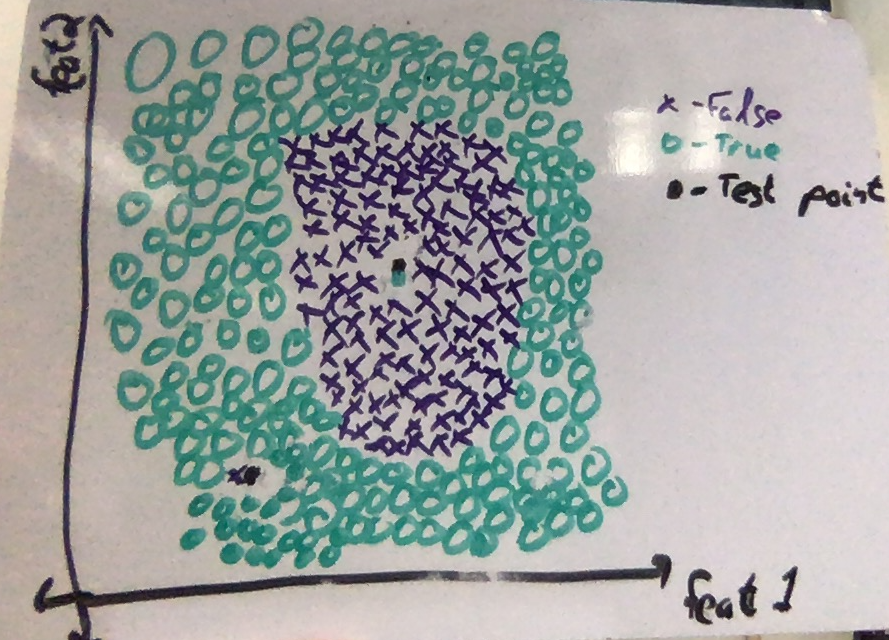

Observe that in the middle of purple x "territory" there is a lone green circle. If we happen to have a test point next to that lone green circle, the test point's nearest neighbor would be the green circle, so nearest neighbor would predict green circle for the test point.

This isn't crazy, but it probably doesn't match our human intuition for what the test point's label should be since it's surrounded by so many purple x's. 

The same reasoning applies for the test point next to the lone purple x in the middle of green circle "territory".

## kNN pseudocode:
Below is some rough pseudocode for kNN. Recall that pseudocode does not have to get all of the details of syntax perfectly correct. It can even invent notations that no language has as long as it is clear from context what the goal is.
    
    inputs: train_points: an N by D matrix of training points (each row is a training point)
            train_labels: an N-vector of labels corresponding to each training point
            test_points: an M by D matrix of test points
    output: an M-vector of labels corresponding to the predicted label of each testing point
    procedure:
    results = [NA] * M
    for i in 1,...,M:
        test_point = test_points[i]
        distances = rowwise_norm(train_points - test_point)
        neighbor_indices = argsort(distances)[from 0 to k]
        neighbor_labels = train_labels[neighbor_indices]
        results[i] = most_frequent(neighbor_labels)
    return results
    
It is not too much work to turn this pseudocode into actual code but it requires a few numpy tricks to get all the details just right.

In [82]:
def knn(train_points, labels, test_points, k):
    results = np.full((test_points.shape[0],), False)
    for i, test_point in enumerate(test_points):
        dist_vector = np.linalg.norm(train_points - test_point, axis=1)
        knn_indices = np.argsort(dist_vector)[:k]
        knn_labels = labels[knn_indices]
        unique_labels, counts = np.unique(knn_labels, return_counts=True)
        most_popular_label_index = np.argmax(counts)
        most_popular_label = unique_labels[most_popular_label_index]
        results[i] = most_popular_label
        # compressed version:
        # unique_labels, counts = np.unique(labels[ np.argsort(dist_vector)[:k] ], return_counts=True)
        # results[i] = unique_labels[np.argmax(counts)]
        ##########################################
        # compressed version that's also faster:
        # unique_labels, counts = np.unique(labels[ np.argpartition(dist_vector, k)[:k] ],
        #                              return_counts=True)
        # results[i] = unique_labels[np.argmax(counts)]
    return results

In [102]:
guesses = knn(train_points, train_labels, test_points, 40)
print(accuracy(test_labels, guesses))

0.82


# How do we choose k?
We would like to be able to find the k that makes our performance as good as possible.

One idea: 
* Use our training set to train a model with a bunch of different k values. 
* Test each model on our test set and compute its accuracy. 
* Choose the k whose model has the best test performance

DON'T DO THIS!!!

What's wrong with this?

This would be making a decision about our model(s) using the test data. Our test accuracy is now no longer a good estimate of performance on future data. It might just so happen that the k we chose happened to be particularly good for our test data

That said, the core of the above idea is actually very good. 

Better idea:
* Split our dataset yet again. We will now have 3 datasets: training set, validation set, and testing set
* Use our training set to "train" a model for various k values, making predictions for our validation set
* Evaluate the performance of each model on our validation set
* Choose the k whose model has the best test performance

We've now chosen k.

We now have 2 options for which trained model we should use going forward:
(1) use that same best model we found on validation.
(2) Combine our training set and validation set. Our new model will use this combined set as a training set

Either way, we should test our model on the testing set and evaluate its performance. This is our best estimate for how well our model will work on new unseen data

Q: What do you think might be the benefits of either option?

A: 

The 2nd option makes our new training set larger. In general, this additional data might be helpful for new points. 

However, with this larger, different dataset the optimal k value we found might no longer be the best choice. Most of the time, the k value will still be somewhat reasonable especially if the validation set is relatively small in comparison to the training set.

# Overfitting, underfitting, and generalization
**generalization** the ability of a model to generalize, that is, to use prior knowledge (from the training set) to perform well on new data; we can measure this analytically by looking at the generalization gap

**generalization gap**: The difference between training accuracy (or similar measurement) and testing accuracy

**overfitting**: when a model captures the peculiarities of the particular training set rather than the general trends and pattern; generally this occurs through some combination of the model being too complex or not having enough data (or data that isn't varied enough);  large generalization gap

**underfitting**: when a model fails to capture very much at all; poor training (and thus, also, poor test) accuracy (or similar measurement)

Note that overfitting and underfitting are broad labels that can be applied hazily

Q: Can your model overfit and underfit at the same time?
A: In a certain manner of speaking, yes.

When a model performs poorly on the training set and still performs much worse on the validation (or test) set, this situation could reasonably be described as simultaneously overfitting and underfitting.

**parameter**: a "knob" or "switch" that controls how our model works and which we set using our training data; actually we have not yet met a parameter. k nearest neighbor is sometimes called a nonparametric for this reason

**hyperparameter**: a "knob" or "switch" that controls how our model works and which we set using our validation (aka development aka val aka dev)  data; k in k-NN is a classic example of a hyperparameter


## kNN demo
Try out this [demo](http://vision.stanford.edu/teaching/cs231n-demos/knn/) to get a little more sense for what's happening with kNN